# Movie Industry Analysis 
## Part II - Data Exploration
---
This personal project was undertaken in order for me to become comfortable using Pandas for larger data sets and also for practicing basic machine learning tasks. 

It consists of Three Different Notebooks: 

* **Part I   - Data Preparation**
* **Part II  - Data Exploration (This Notebook)**
* **Part III - Predictions with Machine Learning**

The data mining process is followed througout the project, both on a large scale and in Parts II & III on a case by case basis. The steps are: 

1. Defining the Objective
2. Data Preparation
3. Data Exploration
4. Building (or Choosing) a Model
5. Evaluating Model Results

---
## 1. Defining the Objective
The overall objective of this project is to predict which directors and/or actors will give a movie the best possible IMDB score for any given target year (between 1930 and 2015) using the prior 20 years worth of data for analysis.

---
## 2. Population Analysis
The population data was prepared in Part I.

Note that the data is a hypothetical population used just for this project as I do not have access to all metrics possible through IMDB.

Samples are going to be created from the population in increments of 20 years prior to the test year in question in order to provide enough past data on directors and actors to make a (hopefully) decent prediction.

When creating the samples, there are a couple of assumptions being made:
1. That the average IMDB scores are valid for determining a movies success
2. That all directors and actors are alive during the sample time period (I will use logical tests to weed these out afterward)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pop = pd.read_csv('data/movies_final.csv')
pop.head()

#print(pop.shape)
#pop.info()

,mov_id,title,genre,year,director,dir_dth_yr,actr1,actr2,actr3,runtime,imdb_score,num_scores
0,tt0001184,Don Juan de Serrallonga,Drama,1910,Alberto Marro,1956,Dolores Puchol,Cecilio Rodriguez de la Vega,NaN,58,3.1,11
1,tt0001258,The White Slave Trade,Drama,1910,August Blom,1947,Ellen Diedrich,Victor Fabian,Julie Henriksen,45,5.7,79
2,tt0001498,The Battle of Trafalgar,Drama,1911,J. Searle Dawley,1949,Sydney Booth,Herbert Prior,James Gordon,51,7.2,5
3,tt0001790,"Les Miserables, Part 1: Jean Valjean",Drama,1913,Albert Capellani,1931,Henry Krauss,Henri Etievant,Maria Ventura,60,5.8,21
4,tt0001812,Oedipus Rex,Drama,1911,Theo Frenkel,1956,Suzanne de Baere,Theo Frenkel,NaN,56,5.8,6


## Population Descriptive Stats

In [31]:
print(round(pop.describe(),1))
print()
print(pop.corr())

           year  dir_dth_yr   runtime  imdb_score  num_scores
count  177095.0    177095.0  177095.0    177095.0    177095.0
mean     1989.5      7406.8      96.4         6.0      4482.0
std        26.2      3747.8      33.9         1.3     36582.3
min      1910.0      1913.0      40.0         1.0         5.0
25%      1971.0      2007.0      85.0         5.3        22.0
50%      1998.0      9999.0      93.0         6.2        84.0
75%      2012.0      9999.0     105.0         6.9       440.0
max      2020.0      9999.0   10062.0        10.0   2210134.0

                year  dir_dth_yr   runtime  imdb_score  num_scores
year        1.000000    0.776734  0.123503   -0.095100    0.055159
dir_dth_yr  0.776734    1.000000  0.075582   -0.092381    0.054621
runtime     0.123503    0.075582  1.000000    0.101533    0.071592
imdb_score -0.095100   -0.092381  0.101533    1.000000    0.104773
num_scores  0.055159    0.054621  0.071592    0.104773    1.000000


---
## IMDB Score Variable
I first examine 'imdb_score' as this variable is the lynchpin to my analysis. It represents the average user rated score per movie and has a scale from 1 - 10 

In [5]:
scr_hist = pop.copy()
scr_hist = scr_hist.drop(columns = ['mov_id', 'title', 'year', 'genre', 'director', 'dir_dth_yr',
                                    'actr1', 'actr2', 'actr3', 'runtime', 'num_scores'])
print(round(scr_hist.describe(),1))
print()
print(stats.describe(scr_hist['imdb_score']))

       imdb_score
count    177095.0
mean          6.0
std           1.3
min           1.0
25%           5.3
50%           6.2
75%           6.9
max          10.0

DescribeResult(nobs=177095, minmax=(1.0, 10.0), mean=5.986600976876817, variance=1.5711926742748537, skewness=-0.6086002665985205, kurtosis=0.49374072752223164)


### Based on the descriptive stats above, the IMDB score distribution appears to be relatively normal as the mean and median are close together (6.0 and 6.2 respectively). There appears to be a slight left skew based on the median > mean and skewness -0.6. 

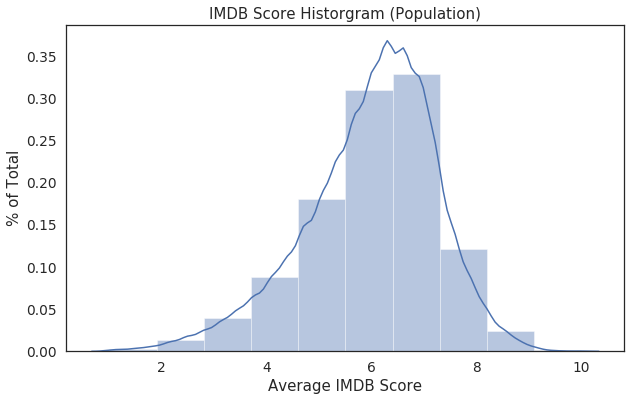

In [6]:
sns.set(style="white", font_scale=1.25)

fig = plt.subplots(figsize=(10,6))
ax = sns.distplot(scr_hist, bins=10).set_title('IMDB Score Historgram (Population)')

plt.xlabel('Average IMDB Score')
plt.ylabel('% of Total')

plt.show()

### The historgram above shows that the distribution is fairly normal, there is a slight left skew due to a disproportionate amount of lower scores, but this is not an unexpected outcome in my opinion and is not cause for alarm. 

## Test 1: Calculate mean of sample means & the mean of sample standard devations for the 'imdb_score' variable
Because I have 86 possible samples in in my analysis, I can use the average of sample means in order to get a better idea of the mean population and the average of sample standard deviations for mean population standard deviation.

In [6]:
def avg_of_sample_means():
    averages = []
    std = []
    
    # All Possible Target Years
    tgt_years = pop['year'][(pop['year'] >= 1930) &
                            (pop['year'] <= 2015)].unique().tolist()
    tgt_years.sort()
    
    print(f'Number of Years Tested: {len(tgt_years)}')

    for yr in tgt_years:    
        sample = pop[(pop['year'] >= yr-20) & (pop['year'] <= yr+4)]
        averages.append(round(sample["imdb_score"].mean(),1))
        std.append(round(sample["imdb_score"].std(),1))
        
    avg_means = sum(averages) / len(tgt_years)
    print(f'Average of All Sample Means: {round(avg_means, 1)}')
    
    avg_std = sum(std) / len(tgt_years)
    print(f'Average of All Sample Standard Deviations: {round(avg_std, 1)}')

avg_of_sample_means()

Number of Years Tested: 86
Average of All Sample Means: 6.1
Average of All Sample Standard Deviations: 1.1


## Test 1 Conclusions:
* Approximate Population Mean IMDB Scores:   6.1
* Approximate Population STD of IMDB Scores: 1.1


* Movies with an average IMDB score > 6.1 are more successful than 50% of all movies.
* Movies with an average IMDB score > 7.2 are more successful than 68% of all movies.
* Movies with an average IMDB score > 8.3 are more successful than 95% of all movies. 
* Movies with an average IMDB score > 9.4 are more successful than 99.7% of all movies.

---
## IMDB Number of Scores Variable
The 'num_scores' variable contains the actual number of user votes used to calculate the average IMDB Score per movie. 

In [45]:
num_scr = pop.copy()
num_scr = num_scr.drop(columns = ['mov_id', 'title', 'year', 'genre', 'director', 
                                  'dir_dth_yr','actr1', 'actr2', 'actr3', 'runtime'])
print(round(num_scr.describe(),1))
print()
print(stats.describe(num_scr['num_scores']))
print()
print(num_scr.corr())

       imdb_score  num_scores
count    177095.0    177095.0
mean          6.0      4482.0
std           1.3     36582.3
min           1.0         5.0
25%           5.3        22.0
50%           6.2        84.0
75%           6.9       440.0
max          10.0   2210134.0

DescribeResult(nobs=177095, minmax=(5, 2210134), mean=4482.029142550608, variance=1338267182.4054267, skewness=20.92158034792162, kurtosis=664.868155375121)

            imdb_score  num_scores
imdb_score    1.000000    0.104773
num_scores    0.104773    1.000000


### The first thing that jumps out is that 'num_scores' has a massive range (not surprising) from 5 to 2.2 million. Furthermore, the median number of votes is 84 which means that roughly 75k titles have < 84 votes. The skew of 20 and kurtosis of 664 show that the data set is highly postively skewed with a large number of outliers.

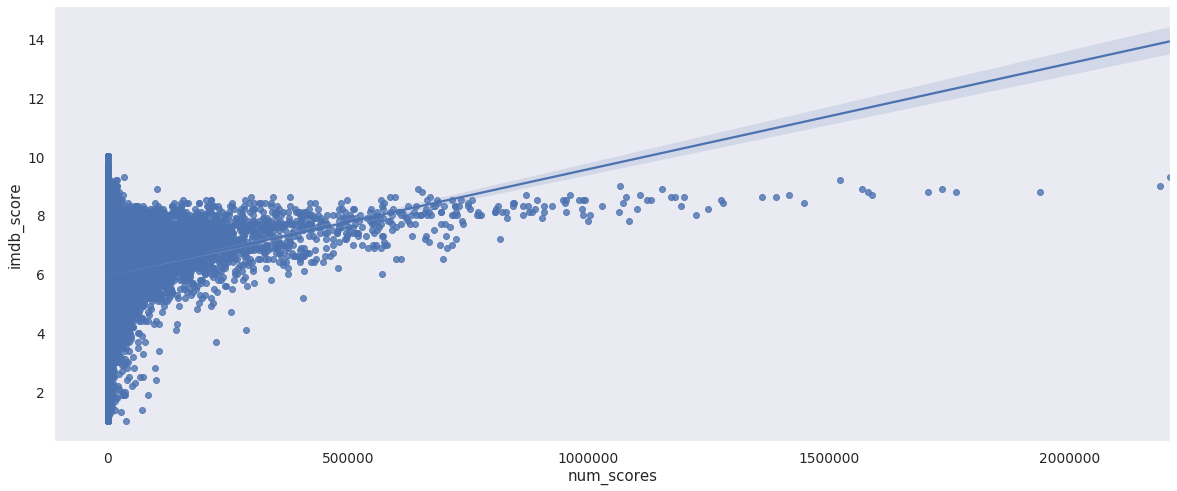

In [8]:
sns.set(style="dark", font_scale=1.25)
fig = plt.subplots(figsize=(20,8))
sns.regplot(x="num_scores", y="imdb_score", data=num_scr);

### The scatter plot shows that the higher (outlier) scores counts (approximatley > 300k) appear to have above average scores. Yet, there is very little correlation being shown from the correlation coefficient (0.10) which is not what I would expect to see

### Because I expect there to be a higher correlation than 0.10 both logically and based on the scatter chart, I re-test checking the stats for the imdb_scores < 100k and > 100k, with the expectation that the scores > 100k will be higher on average

## Test 2: Check if extreme outliers for the 'num_counts' variable result in higher average IMDB Scores

In [9]:
print('Scores with > 100k Votes')
print(round(pop[pop['num_scores'] >= 100_000].describe(),1))
print()
print('Scores with < 100k Votes')
print(round(pop[pop['num_scores'] < 100_000].describe(),1))

Scores with > 100k Votes
         year  dir_dth_yr  runtime  imdb_score  num_scores
count  1804.0      1804.0   1804.0      1804.0      1804.0
mean   2002.9      9258.6    116.2         7.1    272211.0
std      14.3      2318.8     21.5         0.8    230605.7
min    1921.0      1949.0     64.0         3.4    100023.0
25%    1999.0      9999.0    101.0         6.5    133382.0
50%    2007.0      9999.0    114.0         7.2    192974.0
75%    2012.2      9999.0    128.0         7.7    316759.0
max    2019.0      9999.0    238.0         9.3   2210134.0

Scores with < 100k Votes
           year  dir_dth_yr   runtime  imdb_score  num_scores
count  175291.0    175291.0  175291.0    175291.0    175291.0
mean     1989.4      7387.7      96.2         6.0      1726.7
std        26.3      3755.0      34.0         1.3      7731.4
min      1910.0      1913.0      40.0         1.0         5.0
25%      1971.0      2007.0      84.0         5.2        21.0
50%      1998.0      9999.0      93.0         

## Test 2 Conclusions:
* Movies with 'num_scores' > 100k have aveage IMDB scores 1.1 points or 18.3% higher than those movies with less than 100k votes.  

These results makes sense as extremely popular movies should have more viewers than less popular movies and therefore should posses a larger pool of potential individuals to rate a given movie on IMDB.

---
## Runtime Variable
The 'runtime' variable represents the length in minutes of a particular movie. 

In [12]:
runtime = pop.copy()
runtime = runtime.drop(columns = ['mov_id', 'title', 'year', 'genre', 'director', 'dir_dth_yr',
                                  'actr1', 'actr2', 'actr3', 'num_scores'])
print(round(runtime.describe(),1))
print()
print(stats.describe(runtime['runtime']))
print()
print(runtime.corr())

        runtime  imdb_score
count  177095.0    177095.0
mean       96.4         6.0
std        33.9         1.3
min        40.0         1.0
25%        85.0         5.3
50%        93.0         6.2
75%       105.0         6.9
max     10062.0        10.0

DescribeResult(nobs=177095, minmax=(40, 10062), mean=96.35768937575877, variance=1152.2177553530473, skewness=145.37129009205302, kurtosis=42018.622508936256)

             runtime  imdb_score
runtime     1.000000    0.101533
imdb_score  0.101533    1.000000


### The 'runtime' data appears to have a wide range, much larger than expected. the max value is 10,062 minutes which tells me that something is not right with at least that data point. Because the mean and median are relatively close together, I suspect that these high outliers are the cause for the high skew.

## Test 3: Check if Runtime Effects Average IMDB Score

### First I perform a quck outlier test by pulling all the rows where the runtime is > 3 standard devations from the mean. I use 210 minutes because this is close to the 3 std amount and I would suspect that the vast majority of movies would fall below this length. 

In [13]:
pop[pop['runtime'] > 210]

,mov_id,title,genre,year,director,dir_dth_yr,actr1,actr2,actr3,runtime,imdb_score,num_scores
37,tt0003159,"Les Miserables, Part 2: Fantine",Drama,1913,Albert Capellani,1931,Maria Ventura,Maria Fromet,Mistinguett,300,5.7,19
54,tt0003675,The Beloved Adventurer,Action,1914,Arthur V. Johnson,1916,Arthur V. Johnson,Lottie Briscoe,Florence Hackett,450,6.5,10
71,tt0004052,The Hazards of Helen,Action,1914,J. Gunnis Davis,1937,Helen Holmes,Helen Gibson,J.P. McGowan,1428,6.9,80
81,tt0004272,Lucille Love: The Girl of Mystery,Action,1914,Francis Ford,1953,Grace Cunard,Francis Ford,Harry Schumm,300,5.9,8
83,tt0004313,The Master Key,Action,1914,Robert Z. Leonard,1968,Robert Z. Leonard,Ella Hall,Harry Carter,310,4.9,11
...,...,...,...,...,...,...,...,...,...,...,...,...
175340,tt9047474,La Flor,Drama,2018,Mariano Llinas,9999,Elisa Carricajo,Valeria Correa,Pilar Gamboa,808,7.9,303
175369,tt9055926,National Theatre Live: King Lear,Drama,2018,Jonathan Munby,9999,Ian McKellen,Sinead Cusack,Danny Webb,227,8.6,203
175516,tt9097864,My Thesis Film: A Thesis Film by Erik Anderson,Drama,2018,Erik Anderson,9999,Erik Anderson,Amnon Buchbinder,Shannon Currie,233,8.9,25
175901,tt9249616,Amor de Perdicao,Drama,1979,Manoel de Oliveira,2015,Antonio Sequeira Lopes,Cristina Hauser,Elsa Wallencamp,262,7.7,29


### Only 449 movies out of 177,000 or 0.002% of the total are longer than 3.5 hours, therefore I remove them and retest to see if these outliers were the cause of the skewed data.

In [14]:
print(round(pop[pop['runtime'] <= 210].describe()))
print()
print(stats.describe(pop['runtime'] <= 210))

           year  dir_dth_yr   runtime  imdb_score  num_scores
count  176646.0    176646.0  176646.0    176646.0    176646.0
mean     1990.0      7414.0      96.0         6.0      4484.0
std        26.0      3745.0      21.0         1.0     36606.0
min      1910.0      1913.0      40.0         1.0         5.0
25%      1971.0      2007.0      85.0         5.0        22.0
50%      1998.0      9999.0      93.0         6.0        84.0
75%      2012.0      9999.0     105.0         7.0       440.0
max      2020.0      9999.0     210.0        10.0   2210134.0

DescribeResult(nobs=177095, minmax=(False, True), mean=0.9974646376238742, variance=0.002528948593928193, skewness=-19.78442511721795, kurtosis=389.42347721880395)


In [15]:
pop[pop['runtime'] <= 210].corr()

,year,dir_dth_yr,runtime,imdb_score,num_scores
year,1.000000,0.776352,0.216835,-0.095212,0.055240
dir_dth_yr,0.776352,1.000000,0.135237,-0.092167,0.054761
runtime,0.216835,0.135237,1.000000,0.144236,0.116139
imdb_score,-0.095212,-0.092167,0.144236,1.000000,0.104752
num_scores,0.055240,0.054761,0.116139,0.104752,1.000000


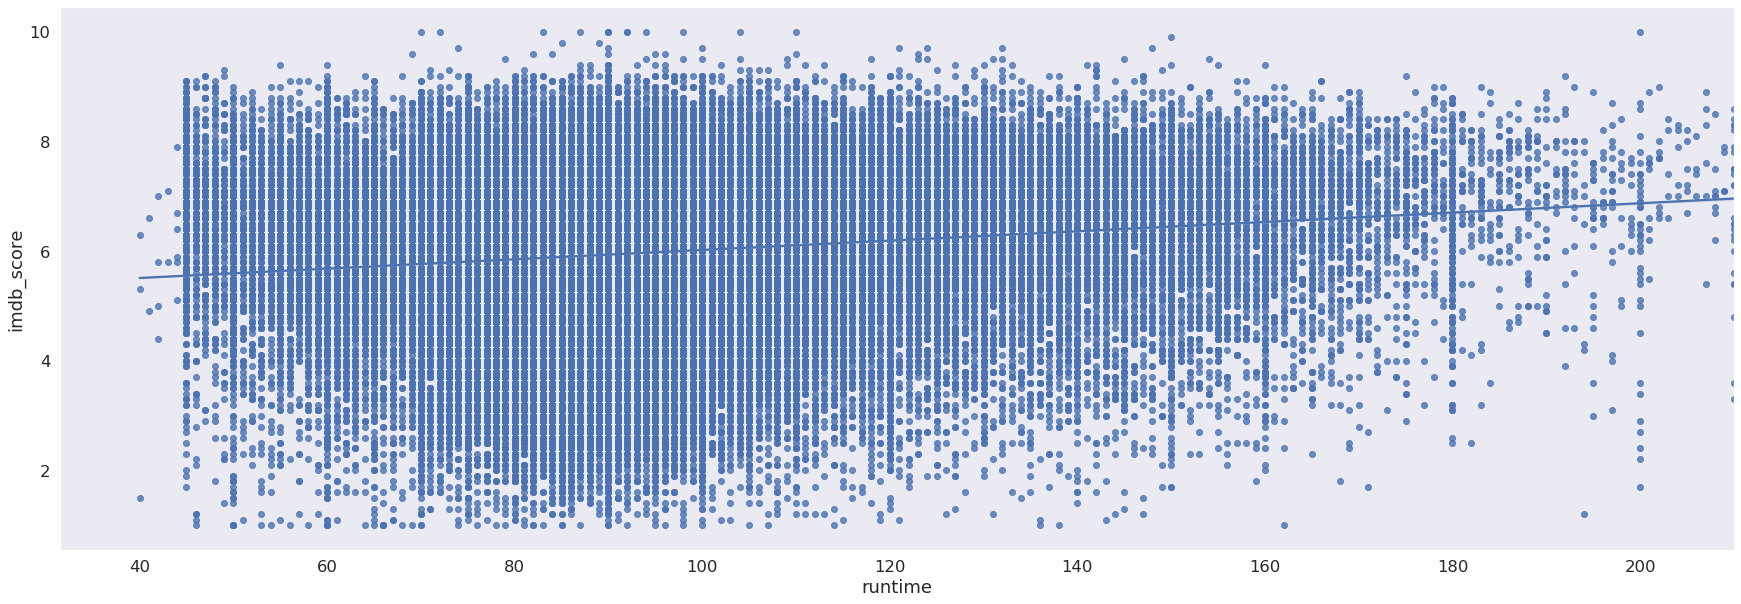

In [16]:
sns.set(style="dark", font_scale=1.5)
fig = plt.subplots(figsize=(30,10))
sns.regplot(x="runtime", y="imdb_score", data=pop[pop['runtime'] <=210])

### After removing the outliers, the correlation between runtime and imdb_scores increased slightly from 0.10 to 0.14, furthermore the distribution is now approximately symmetric. Thus indicating that the oultiers were causing the skew.

### Because of the skew, I split the runtime data at the 75th percentile and compare the imdb_score means. It turns out that movies > 1.5 hours in length tend to have scores half a point higher on average. 

In [17]:
print('Movie length >= 105 minutes ')
print(round(pop[pop['runtime'] >= 105].describe(),1))
print()
print('Movie length < 105 minutes')
print(round(pop[pop['runtime'] < 105].describe(),1))

Movie length >= 105 minutes 
          year  dir_dth_yr  runtime  imdb_score  num_scores
count  44784.0     44784.0  44784.0     44784.0     44784.0
mean    1995.7      7953.9    125.3         6.4     11372.0
std       22.0      3491.1     54.8         1.2     65556.5
min     1912.0      1916.0    105.0         1.0         5.0
25%     1982.0      2019.0    110.0         5.8        34.0
50%     2004.0      9999.0    118.0         6.5       178.0
75%     2013.0      9999.0    134.0         7.1      1230.0
max     2020.0      9999.0  10062.0        10.0   2210134.0

Movie length < 105 minutes
           year  dir_dth_yr   runtime  imdb_score  num_scores
count  132311.0    132311.0  132311.0    132311.0    132311.0
mean     1987.4      7221.6      86.6         5.9      2149.9
std        27.2      3813.1      12.0         1.3     17751.2
min      1910.0      1913.0      40.0         1.0         5.0
25%      1968.0      2003.0      81.0         5.1        19.0
50%      1995.0      9999.0    

## Test 3 Conclusions:
* Movies longer than 105 minutes in length have an average IMDB score 0.5 points higher than movies shorter than 105 minutes in length.

## Total Movie Titles Per Decade

In [46]:
yr_chk = pop.copy()
yr_chk = pop.drop(columns = ['mov_id', 'title', 'genre', 'director', 'dir_dth_yr',
                             'actr1', 'actr2', 'actr3', 'runtime', 
                             'imdb_score', 'num_scores'])

decade = 10 * (yr_chk['year'] // 10)
yr_chk['decade'] = decade
yr_chk.groupby('decade')['year'].count()

decade
1910      779
1920     2448
1930     7732
1940     7585
1950    10346
1960    13079
1970    15229
1980    16328
1990    17671
2000    30605
2010    54535
2020      758
Name: year, dtype: int64

**There are an adequate number of movies per decade. Because my initial algorithm is going to use 20 years of data prior to the target date, the entire possible target date range is 1930 - 2015**

---
# 3. Data Exploration & Descriptive Statistics
In this section, I create a sample template and perform mulitple exploratory case studies on it in order to help with my predictive algorithm creation.

### Creating the Sample
My templtae sample has the target year of 2000 which means it uses the years from 1980 - 1999 as its 20 years of predictive data. I also remove movies with runtime > 3.5 hours

In [28]:
s1 = pop.copy()

s1_target = 2000
s1_minyr = 1980  # (s1_target - 20)
s1_maxyr = 1999  # (s1_target -1)

s1 = s1[(s1['year'] >= 1980) & (s1['year'] <= 1999)]
print(f'Initial Sample Size: {s1.shape}')

s1 = s1[s1['runtime'] < 210]
print(f'Sample Size After Runtime Outliers Removed: {s1.shape}')

Initial Sample Size: (33999, 12)
Sample Size After Runtime Outliers Removed: (33938, 12)


In [29]:
print(round(s1.describe()))
print()
print(s1.corr())

          year  dir_dth_yr  runtime  imdb_score  num_scores
count  33938.0     33938.0  33938.0     33938.0     33938.0
mean    1990.0      8086.0     99.0         6.0      5301.0
std        6.0      3410.0     21.0         1.0     43502.0
min     1980.0      1934.0     45.0         1.0         5.0
25%     1985.0      9999.0     88.0         5.0        25.0
50%     1990.0      9999.0     95.0         6.0        94.0
75%     1995.0      9999.0    106.0         7.0       491.0
max     1999.0      9999.0    208.0        10.0   2210134.0

                year  dir_dth_yr   runtime  imdb_score  num_scores
year        1.000000    0.277099  0.029718   -0.039561    0.048165
dir_dth_yr  0.277099    1.000000 -0.047008   -0.026068    0.029116
runtime     0.029718   -0.047008  1.000000    0.219242    0.100343
imdb_score -0.039561   -0.026068  0.219242    1.000000    0.132474
num_scores  0.048165    0.029116  0.100343    0.132474    1.000000


**The sample statsitics are pretty much in line with the population, therefore I can proceed with case by case analysis.**

## Movie Titles Per Year

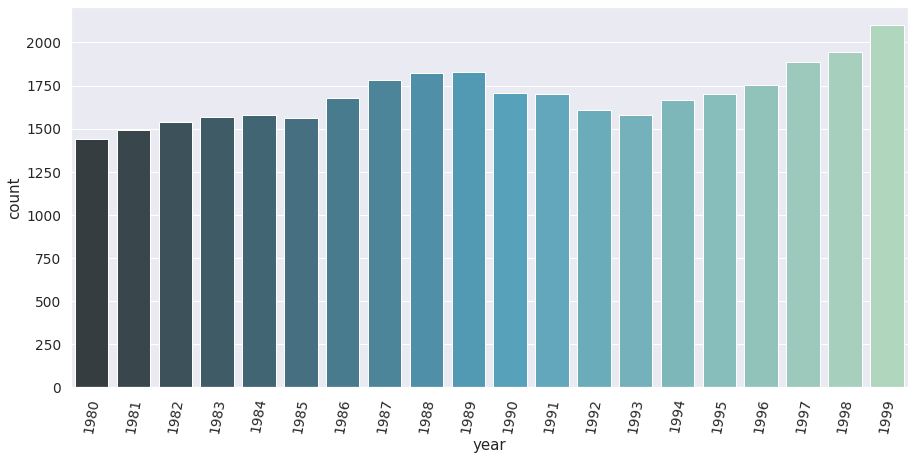

In [30]:
sns.set(style="darkgrid", font_scale=1.25)
fig = plt.subplots(figsize=(15,7))

# use y for horizontal bars
#ax = sns.countplot(y='genre', data=df)

# use y for vertical bars
ax = sns.countplot(x='year', data=s1, palette='GnBu_d')

plt.xticks(rotation=80)
plt.show()

**This chart shows that all years in the sample contain a relatively uniform number of movies per year which is ideal.**

---
## Case 1: Genre Count
* **Objective** - Get a better idea of the genre breakdown
* **Data Points** - (x = 'genre'), (y= title count per genre)
* **Analysis Type** - Vertical & Horizontal Bar Charts

### Create dataframe that counts the titles by genre

In [31]:
gdf = s1.copy()
gdf = gdf.drop(columns = ['mov_id', 'year', 'director', 'dir_dth_yr',
                          'actr1', 'actr2', 'actr3', 'runtime', 
                          'imdb_score', 'num_scores'])
gdf = gdf.groupby('genre').count()
gdf = gdf.reset_index()
gdf['title_pct'] =   round(gdf.title / gdf.title.sum() * 100, 1)

gdf

,genre,title,title_pct
0,Action,5874,17.3
1,Comedy,9246,27.2
2,Drama,15156,44.7
3,Family,1599,4.7
4,Horror,2063,6.1


### Bar Chart
In this example, a subset of the data was used including just the genre and title columns. Doing this allowed the use of groupby() for counting the titles by genre and also allowed for sorting by total count value. 

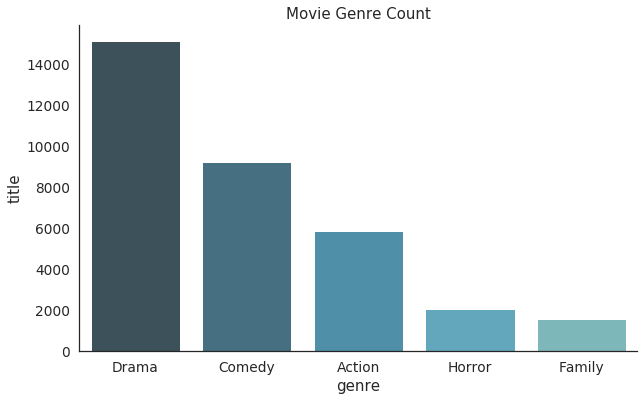

In [32]:
# Sort chart values by title
gdf = gdf.sort_values(by='title', ascending = False)

# Set chart style, color palette, and font size
sns.set(style="white", palette='GnBu_d', font_scale=1.25)

# Set chart size
fig = plt.subplots(figsize=(10,6))

# Chart type & settings
ax = sns.barplot(x="genre", y="title", data=gdf).set_title('Movie Genre Count')

# Remove top and right borders
sns.despine(top=True, right=True)

### Countplot Chart
In this example, the counts created through seaborn using the countplot chart. All that was required was the 'genre' column. However, the big difference between this and the chart above is that sorting this chart does so by the genre names and NOT the count values themselves. 

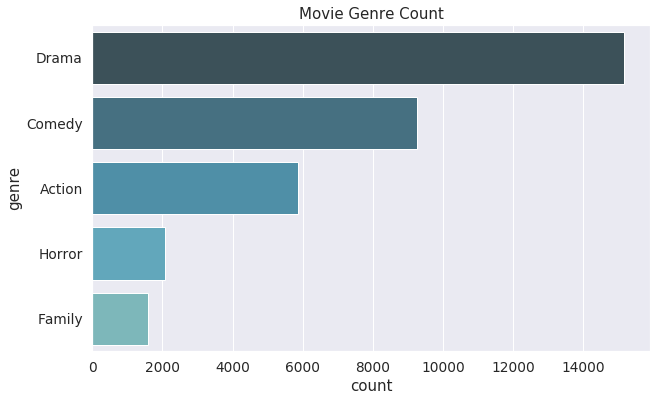

In [33]:
sns.set(style="darkgrid", palette='GnBu_d', font_scale=1.25)

fig = plt.subplots(figsize=(10,6))

# use x for vertical bars
#ax = sns.countplot(x='genre', data=df)

# use y for horizontal bars
ax = sns.countplot(y='genre', data=s1).set_title('Movie Genre Count')

## Case 1 Results:
90% of the movies in the sample are either, Drama, Comedy, or Action, Drama makes up 44% of the total This would suggest that those particular genres are the most popular, however this can't be confirmed without including the IDMB score metrics

**Current Algorithm Metrics:**
* **Average IMDB Score = 6.1**
* **Average IMDB Score STD = 1.1**
* **Number IMDB Score Votes > 100k for extremely popular movies**
* **Ideal Movie Length > 105 Minutes**

---
## Case 2: Genre Popularity Based on IMDB Score
* **Objective** - Compare Imdb Scores by Genre in order to see which is most popular
* **Data Points** - (x = 'genre'), (y= 'imdb_score;')
* **Analysis Type** - Descriptive Statistics

### Samples contain 20 years of data, however, because audiences tastes can change drastically from year to year, I'm going to use the most popular genre for the past 3 years as the target genre for my prediction. 

In [34]:
c4 = s1.copy()

c4 = c4[(c4['year'] >= s1_maxyr-2) & (c4['year'] <= s1_maxyr)]

c4 = c4.drop(columns = ['mov_id', 'title', 'year', 'director', 'dir_dth_yr',
                        'actr1', 'actr2', 'actr3', 'runtime', 'num_scores'])
c4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5931 entries, 45965 to 175870
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   genre       5931 non-null   object 
 1   imdb_score  5931 non-null   float64
dtypes: float64(1), object(1)
memory usage: 139.0+ KB


In [35]:
c4.groupby('genre').mean()

,imdb_score
genre,
Action,5.430593
Comedy,5.880599
Drama,6.143217
Family,5.593056
Horror,5.039223


## Case 2 Results:
Based on IMDB Scores, Drama movies are the most popular, followed by Comedy, Family, Action, and Horror respectively. 

This analysis shows that for predictive purposes of a movies success, choosing to make Drama film could potentially net higher scores than all the other genre types. 

**Current Algorithm Metrics:**
* **Average IMDB Score = 6.1**
* **Average IMDB Score STD = 1.1**
* **Number IMDB Score Votes > 100k for extremely popular movies**
* **Ideal Movie Length > 105 Minutes**
* **Ideal Movie Genre: Highest IMDB Score Mean three years prior to target year**

---
## Case 3: Determine Ideal Directors Per Genre
* **Objective** -  In the title
* **Data Points** - 'title', 'genre', 'director', 'imdb_score', 'num_scores'
* **Analysis Type** - Descriptive Statistics

In [21]:
round(s1.groupby('director').aggregate({'title': 'count','imdb_score': 'mean'}).describe(),1)

,title,imdb_score
count,14477.0,14477.0
mean,2.3,5.9
std,2.9,1.2
min,1.0,1.0
25%,1.0,5.1
50%,1.0,6.0
75%,3.0,6.7
max,87.0,9.6


### From the above results, 75% of directors have < 3 movies, therefore to be considered among one of the top directors for any given two decades of data, a director must have at least 3 movies. 

### I next perform a search based on number of titles and average score.

In [22]:
dir1 = s1.copy()

dir1 = round(dir1.groupby('director').aggregate({'title': 'count','imdb_score': 'mean', 'num_scores' : 'sum'}), 2)

dir1.loc[(dir1['title'] >= 3) & 
           (dir1['imdb_score'] > 6)].sort_values(by='title', ascending=False)

,title,imdb_score,num_scores
director,,,
Jing Wong,63,6.10,58466
K. Raghavendra Rao,37,6.53,7579
Priyadarshan,35,7.08,27308
Hisayasu Sato,34,6.11,3754
Mahesh Bhatt,34,6.13,32912
...,...,...,...
Huanzhang Zhao,3,6.80,44
Howard Franklin,3,6.33,28077
Holger Schott,3,6.53,34


### The above results were not quite what I expected. Tthe directors with the most titles and high scores are unrecognizable to me. I also notice that the number of total votes for all their movies is not very high in most cases. Because of this, I perform another search based on the number of votes and immediately get back what I was looking for, instantly recognizable names. See Below:

In [40]:
dir2 = s1.copy()

# Set Genre
dir2 = dir2[dir2['genre'] == 'Drama']

dir2 = round(dir2.groupby('director').agg({'title': 'count','imdb_score': 'mean', 'num_scores' : 'sum'}),2)

dir2[(dir2['title'] >= 3) & 
     (dir2['imdb_score'] > 6) & 
     (dir2['num_scores'] > 100_000)].sort_values(by='num_scores', ascending=False)

,title,imdb_score,num_scores
director,,,
Quentin Tarantino,3,8.23,2911100
Steven Spielberg,5,7.80,2493560
Martin Scorsese,9,7.56,2121715
Jonathan Demme,3,7.40,1417599
Brian De Palma,8,7.31,1371811
...,...,...,...
Vincent Ward,3,7.03,102557
Stephen Frears,5,7.02,102541
David Cronenberg,3,6.77,102367


### While the above grouping works for just 'num_scores', I would ideally like to have 'imdb_score' sorted AFTER 'num_scores', see below:

In [10]:
dir4 = s1.copy()

# Set Genre
dir4 = dir4[dir4['genre'] == 'Drama']       # select dramas only
dir4 = dir4[dir4['dir_dth_yr'] == 9999]     # remove dead directors

# Group and Aggregate Desired Columns
dir4 = round(dir4.groupby('director').agg({'title': 'count',  
                                           # This selects the mode, not used because set genre directly
                                           #'genre': lambda x:x.value_counts().index[0], 
                                           'imdb_score': 'mean',
                                           'num_scores' : 'sum'}),2)

# Set Algorithm Limits
dir4 = dir4[(dir4['title'] >= 3) & 
            (dir4['imdb_score'] > 6) & 
            (dir4['num_scores'] > 100_000)]

# Sort IMDB Score Counts Largest First
dir4 = dir4.sort_values(by=['imdb_score'], ascending=False)


print(dir4.shape)
print()

# Next Sort IMDB Score, keep 
print('Top 10 Drama Directors Per Imdb Score and Score Count:')
dir4.sort_values(by=['imdb_score', 'num_scores'], ascending=[False,True]).head(10)

(53, 3)

Top 10 Drama Directors Per Imdb Score and Score Count:


,title,imdb_score,num_scores
director,,,
Quentin Tarantino,3,8.23,2911100
David Lynch,4,7.88,580985
Steven Spielberg,5,7.80,2493560
Giuseppe Tornatore,6,7.77,288802
Paul Thomas Anderson,3,7.70,545842
Jim Sheridan,4,7.62,235470
Rob Reiner,4,7.57,754072
Martin Scorsese,9,7.56,2121715
Don Bluth,3,7.37,217961


### I now have a pool of 64 potential directors to choose from of which I will take the top 10 and empirically test them to see if my predictions actually work by checking my target year + 3 years ahead to see if these directors next movie was a success. 

### Ideally they all would be successful, but some directors may or may not have made any movies during that time perios OR the next movie they made was not a drama. 

In [20]:
# This function returns the target year directors next major film (if any)
# within 3 years after target year
#def test_directors(dir_df):
#    df = dir_df.copy()
#    df = df.iloc[0:0] # remove all rows, keep columns
#
#    for d in list(dir_df.index):
#        t = pop[(pop['director'] == d) & 
#                (pop['year'] >= 2000) & 
#                (pop['year'] <= 2003)].sort_values(by=['year'], ascending=True).head(1)
#        df = df.append(t)
#        
#    return(df)
#
#best_dirs = test_directors(dir4)
#best_dirs = best_dirs[best_dirs['genre'] == 'Drama']
#best_dirs.sort_values(['imdb_score'], ascending=False).head(10)


# This function returns the top 10 target year directors next major film (if any)
# within 3 years after target year
def test_directors2(dir_df):
    df = dir_df.copy()
    df = df.iloc[0:10]
    
    result_df = dir_df.copy()
    result_df = df.iloc[0:0]
    
    for d in list(df.index):
        t = pop.copy()
        t = t.drop(columns=['mov_id', 'dir_dth_yr', 'actr1', 'actr2', 'actr3'])
        
        t = t[(t['director'] == d) & 
                (t['year'] >= 2000) & 
                (t['year'] <= 2003)].sort_values(by=['year'], ascending=True).head(1)
        result_df = result_df.append(t)
    return(result_df)
    

results = test_directors2(dir4)

print(f'Number of Results: {len(results)}')

print(results[results['genre'] == 'Drama'].mean())

Number of Results: 8
imdb_score         7.60
num_scores    253201.50
year            2001.50
runtime          141.25
dtype: float64


In [19]:
results[results['genre'] == 'Drama']

,title,imdb_score,num_scores,genre,year,director,runtime
66232,Mulholland Dr.,8.0,303234,Drama,2001.0,David Lynch,147.0
74623,A.I. Artificial Intelligence,7.2,282048,Drama,2001.0,Steven Spielberg,146.0
86573,In America,7.7,39623,Drama,2002.0,Jim Sheridan,105.0
75261,Gangs of New York,7.5,387901,Drama,2002.0,Martin Scorsese,167.0


In [21]:
print(results[results['genre'] != 'Drama'].mean())

imdb_score         7.125
num_scores    297700.500
year            2002.000
runtime          102.500
dtype: float64


In [16]:
results[results['genre'] != 'Drama']

,title,imdb_score,num_scores,genre,year,director,runtime
81974,Kill Bill: Vol. 1,8.1,953510,Action,2003.0,Quentin Tarantino,111.0
74747,Malena,7.5,84540,Comedy,2000.0,Giuseppe Tornatore,108.0
82728,Punch-Drunk Love,7.3,140021,Comedy,2002.0,Paul Thomas Anderson,95.0
88767,Alex & Emma,5.6,12731,Comedy,2003.0,Rob Reiner,96.0


## Case 3 Conclusions:

**Drama Results**
* Mean IMDB score for the drama films was: 7.6
* 100% of the drama films beat the population avearge IMDB Score of 6.1
* 100% of the drama films had a runtime of >= 105 minutes
* 75% of the drama films had a a vote count of > 100k (blockbuster status)

**Non-Drama Results**
* Mean IMDB score for the non-drama films was: 7.1
* 75% of the non-drama films beat the population average IMDB score of 6.1
* 50% of the non-drama films had a runtime of >= 105 minutes
* 50% of the non-rama films had a a vote count of > 100k (blockbuster status)

The results for the single template sample are striking. Of the 10 directors chosen from the algorithm, 8 actually made a movie within 3 year of the target year. of the 8 movies made, half were dramas. The dramas met all the criteria set in the algorithm for a good movie, with the exception of one of the films that did not have > 100k votes. This means that 11/12 metrics passed combined for the drama films or 91.67%. 

The directors who chose not to make dramas (remember they were originally selected as the best drama directors) did not far as well as they only met 7/12 total metrics or 58.3% success rate. 

Overall, all the films except 1 had an above average IMDB rating. 5 of of the films could be considered blockbusters with both hihg imdb_scores and large vote counts > 100k.

---
### Final Test Algorithm Metrics:
* **Average IMDB score = 6.1**
* **Average IMDB score STD = 1.1**
* **Number IMDB score votes > 100k for extremely popular movies**
* **Ideal movie length > 105 minutes**
* **Target movie genre has the highest IMDB Score avg for 3 years prior to target year**
* **Ideal director must have at least 3 movies over past 20 years**
* **Test Top 10 directors (with highest IMDB score, vote count ratio over 20 yr period)**

---
# Due to the success of the drama results in the single test above I next want to put the algorithm to the test with all the samples. 

## Sample Object Creation For Testing

In [3]:
# Create sample with target year and population
class Sample:
    def __init__(self, s, t):
        self.tgt_yr = t              # target year
        self.start_yr = t-20         # analysis start year
        self.end_yr = t-1            # analysis end year
        #self.tst_start_yr = t+1
        #self.tst_end_yr = t+4
        
        self.smpl = s[(s['year'] >= self.start_yr) &       # 20 year analysis range
                      (s['year'] <= self.end_yr)]
         
                      
        # Get ideal genre based on prior 3 years to target (TODO Optimize this if possible)
        def getTargetGenre(self):
            genre = self.smpl.copy()

            genre = genre[(genre['year'] >= (self.end_yr - 2)) &
                              (genre['year'] <= self.end_yr)]

            genre = genre.drop(columns = ['mov_id', 'title', 'year', 
                                          'director', 'dir_dth_yr',
                                          'actr1', 'actr2', 'actr3', 
                                          'runtime', 'num_scores'])

            genre = genre.groupby('genre').mean()
            genre = genre.reset_index()
            genre = genre.sort_values(by=['imdb_score'], ascending=False).head(1).iat[0, 0]
            return genre
        
        self.tgt_genre = getTargetGenre(self)
        
        
    def getTopTenDirectors(self, tgt_num_titles, tgt_score, tgt_num_scores):
        dir_df = self.smpl.copy()
        dir_df = dir_df[dir_df['genre'] ==  self.tgt_genre] # Set Target Genre
        dir_df = dir_df[dir_df['dir_dth_yr'] == 9999]       # Remove Dead Directors

        # Group and Aggregate Desired Columns
        dir_df = round(dir_df.groupby('director').agg({'title': 'count',
                                                       'imdb_score': 'mean',
                                                       'num_scores' : 'sum'}),2)
        # Set Algorithm Limits
        dir_df = dir_df[(dir_df['title'] >= tgt_num_titles) &
                        (dir_df['imdb_score'] >  tgt_score) &
                        (dir_df['num_scores'] > tgt_num_scores)]
        

        # Sort IMDB Score Counts Largest First
        dir_df = dir_df.sort_values(by=['imdb_score'], ascending=False)

        # Next Sort IMDB Score, keep 
        print('Top 10 Drama Directors Per Imdb Score and Score Count:')
        print(dir_df.sort_values(by=['imdb_score', 'num_scores'], ascending=[False,True]).head(10))
        print()
        
    
    def getSampleInfo(self):
        if self.tgt_yr >= 1930 and self.tgt_yr <= 2015:
            print(f'Sample Size: {self.smpl.shape}')
            print(f'Target Year: {self.tgt_yr}')
            print(f'Analysis Start Year: {self.start_yr}')
            print(f'Analysis End Year: {self.end_yr}')
            print(f'Target Genre: {self.tgt_genre}\n')
            #print(f'Test Start Year: {self.tst_start_yr}')
            #print(f'Test End Year: {self.tst_end_yr}\n')
        else:
            print(f'Target year {self.tgt_yr} not valid, use range: >= 1930 and <= 2015.')
         
            

#    def get_sample_stats(self):
#        # Remove runtime outliers to prevent skew
#        self.desc_stats = self.smpl[self.smpl['runtime'] < 210]        
#        print('Sample Descriptive Statistics:')
#        return(self.desc_stats.describe().round(decimals=1))


#    def score_hgram(self):
#        self.hist = self.smpl.copy()
#        self.hist = self.hist.drop(columns = ['mov_id', 'title', 'year', 'genre', 'director',
#                                              'dir_dth_yr', 'actr1', 'actr2', 'actr3',
#                                              'runtime', 'num_scores'])
#        sns.set(style="white", font_scale=1.25)
#        fig = plt.subplots(figsize=(10,6))
#        ax = sns.distplot(self.hist, bins=10).set_title(f'Histogram: IMDB Scores ({self.start_yr} - {self.end_yr})')
#        plt.xlabel('Average IMDB Scores')
#        plt.ylabel('% of Total')
#        plt.show()
  

## Test2:  Check to see if director algorithm holds for every possible target year

In [4]:
# population data 


def testSamples():
    pop = pd.read_csv('data/movies_final.csv')  # Initial Population
    tgt_score = 6.1                             # Target  Score
    tgt_std = 1.1                               # Target Standard Deviation
    tgt_num_scores = 100_000                    # Target Number of Scores
    tgt_runtime = 105                           # Target Movie Length
    tgt_num_titles = 3                          # Minimun Number of Movies Per Director
    tgt_genre = ''                              # Target Genre

    # Target Analysis Range (20 Year Range)
    tgt_years = pop['year'][(pop['year'] >= 1930) & (pop['year'] <= 2015)].unique().tolist()
    tgt_years.sort()
    tst_yrs = [2000, 1950]

    #Test Target Years
    for yr in tst_yrs:    
        sample = Sample(pop.copy(), yr)
        #sample.getSampleInfo()
        #tgt_genre = sample.tgt_genre
        sample.getTopTenDirectors(tgt_num_titles, tgt_score, tgt_num_scores)
        

        
    #test_s = Sample(pop, 1930)
    #return(test_s.smpl)
    
testSamples()

Top 10 Drama Directors Per Imdb Score and Score Count:
                      title  imdb_score  num_scores
director                                           
Quentin Tarantino         3        8.23     2911100
David Lynch               4        7.88      580985
Steven Spielberg          5        7.80     2493560
Giuseppe Tornatore        6        7.77      288802
Paul Thomas Anderson      3        7.70      545842
Jim Sheridan              4        7.62      235470
Rob Reiner                4        7.57      754072
Martin Scorsese           9        7.56     2121715
Don Bluth                 3        7.37      217961
Oliver Stone             10        7.34     1028669

Top 10 Drama Directors Per Imdb Score and Score Count:
Empty DataFrame
Columns: [title, imdb_score, num_scores]
Index: []

